# NLP - Sentiment Analysis for Amazon Product Reviews
# Pre-trained Models: Vader vs. Roberta

In this notebook we will be doing sentiment analysis using multiple techniques:

- A) VADER - Valence Aware Dictionary & Sentiment Reasoner (Bag of words approach)
- B) Roberta Pre-trained Model - Transformer-based model by Hugging Face

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Libraries for VADER 
from tqdm.notebook import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Libraries for Roberta Pre-trained Model
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

# To set gray background at graphs
plt.style.use('ggplot')

In [2]:
# Read scraped results from CSV
df = pd.read_csv('Whey_Protein_Amazon_Preprocessed_Reviews.csv')

In [3]:
# Change data type for 'Review' to 'string' & fill empty cells (from CSV) with NA
df['Reviews'] = df['Reviews'].astype('string')
df = df.fillna('NA')

## VADER Sentiment Analysis Approach

In [6]:
sia = SentimentIntensityAnalyzer()
results = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['Reviews']
    myid = row['ID']
    results[myid] = sia.polarity_scores(text)

  0%|          | 0/3314 [00:00<?, ?it/s]

In [7]:
vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns = {'index': 'ID'})
vaders = vaders.merge(df, how = 'left')

In [8]:
vaders.head()

,ID,neg,neu,pos,compound,Unnamed: 0,Product_Name,Date,Rating_Score,Reviews,Link,Product_ID
0,0,0.028,0.667,0.305,0.9720,0,NatureWorks-HydroMATE-Electrolytes-Chocolate-C...,2023-01-25,5.0,I love this. I make it for myself and my kids...,https://www.amazon.com/NatureWorks-HydroMATE-E...,B0BRT77ZK8
1,1,0.000,0.890,0.110,0.3818,1,NatureWorks-HydroMATE-Electrolytes-Chocolate-C...,2023-02-06,5.0,Takes away lightheadedness and makes my husba...,https://www.amazon.com/NatureWorks-HydroMATE-E...,B0BRT77ZK8
2,2,0.000,0.631,0.369,0.9060,2,NatureWorks-HydroMATE-Electrolytes-Chocolate-C...,2023-01-27,5.0,The chocolate tastes delicious! I drink it ev...,https://www.amazon.com/NatureWorks-HydroMATE-E...,B0BRT77ZK8
3,3,0.000,0.618,0.382,0.9146,3,NatureWorks-HydroMATE-Electrolytes-Chocolate-C...,2023-01-27,5.0,I absolutely love this! My buddy gave me a fe...,https://www.amazon.com/NatureWorks-HydroMATE-E...,B0BRT77ZK8
4,4,0.013,0.873,0.114,0.9866,4,NatureWorks-HydroMATE-Electrolytes-Chocolate-C...,2023-02-18,4.0,I like to work out regularly. This includes w...,https://www.amazon.com/NatureWorks-HydroMATE-E...,B0BRT77ZK8


In [9]:
# VADER results on example
example_text = df['Reviews'][3]
print(example_text)
sia.polarity_scores(example_text)


I absolutely love this! My buddy gave me a few of his and immediately I was sold! Taste is pretty good also!!!



{'neg': 0.0, 'neu': 0.618, 'pos': 0.382, 'compound': 0.9146}

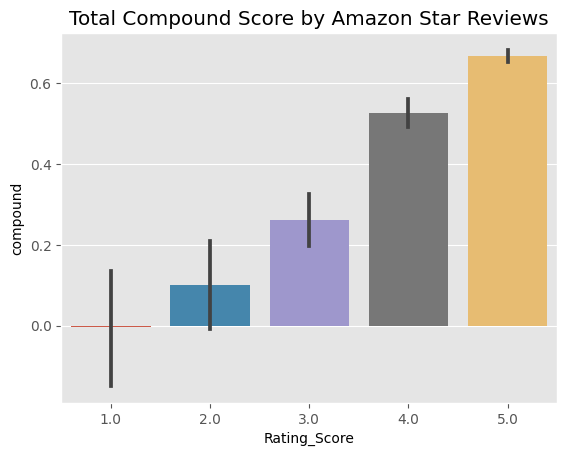

In [10]:
# Set up visualization
ax = sns.barplot(data = vaders, x = 'Rating_Score', y = 'compound')
ax.set_title('Total Compound Score by Amazon Star Reviews')
plt.show()

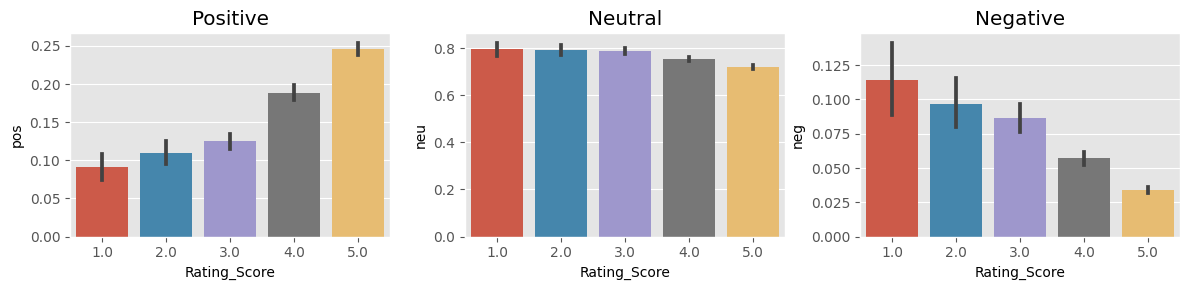

In [11]:
# Set up visualization
fig, axs = plt.subplots(1, 3, figsize = (12, 3))
sns.barplot(data = vaders, x = 'Rating_Score', y = 'pos', ax = axs[0])
sns.barplot(data = vaders, x = 'Rating_Score', y = 'neu', ax = axs[1])
sns.barplot(data = vaders, x = 'Rating_Score', y = 'neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Note that within the 'positive' chart, as expected - positive sentiment is biased towards customers who provided a
# 5-star comment. Interestingly, neutral sentiment is slightly biased towards negative comments.

## Roberta Model Sentiment Analysis Approach

1. Use a model trained of a large corpus of data.
2. Transformer model accounts for the words but also the context related to other words.

Notice that Vader's approach took into account individual words only, but doesn't take into account aspects such as tone, relationship among words, sarcasm, or context.

In [4]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [15]:
# For comparison purposes - let's look again at VADER's example
sia.polarity_scores(example_text)

{'neg': 0.0, 'neu': 0.618, 'pos': 0.382, 'compound': 0.9146}

In [10]:
# Run for Roberta Model - notice positive 'scoring' was higher for Roberta with .992 vs. Vader with .382
encoded_text = tokenizer(example_text, return_tensors = 'pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0016667172, 'roberta_neu': 0.0064371177, 'roberta_pos': 0.9918962}


In [11]:
# Now we define a function based on previous cell - to see roberta's polarity. 
# Polarity refers to aiming towards being able to differentiate & measure the 
# opinion's intensity into 'positive' and 'negative'.

def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors = 'pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [12]:
# We now compile results from both models and print IDs for those reviews that caused a runtime issue 
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Reviews']
        myid = row['ID']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/3314 [00:00<?, ?it/s]

Broke for id 98
Broke for id 102
Broke for id 107
Broke for id 130
Broke for id 166
Broke for id 195
Broke for id 580
Broke for id 704
Broke for id 716
Broke for id 731
Broke for id 1111
Broke for id 1112
Broke for id 1381
Broke for id 1485
Broke for id 1808
Broke for id 1815
Broke for id 1828
Broke for id 1846
Broke for id 2179
Broke for id 2403
Broke for id 2913
Broke for id 4596
Broke for id 4606
Broke for id 4608
Broke for id 4611
Broke for id 4613
Broke for id 4614
Broke for id 4618
Broke for id 4630
Broke for id 5696
Broke for id 5765
Broke for id 5771
Broke for id 5777
Broke for id 5792
Broke for id 5896
Broke for id 5902
Broke for id 5903
Broke for id 5905
Broke for id 5908
Broke for id 5912
Broke for id 5917
Broke for id 5923
Broke for id 5926
Broke for id 5929
Broke for id 5930
Broke for id 5934
Broke for id 5940
Broke for id 5948
Broke for id 6338
Broke for id 6349
Broke for id 6363
Broke for id 6377
Broke for id 6378
Broke for id 6379


In [21]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns = {'index': 'ID'})
results_df = results_df.merge(df, how ='left')
#col_0 = results_df.columns[8]
#results_df.drop(col_0, axis = 1, inplace = True)

In [22]:
results_df.columns

Index(['ID', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'Product_Name', 'Date',
       'Rating_Score', 'Reviews', 'Link', 'Product_ID'],
      dtype='object')

## Review Examples: Specifically Positive 1-Star and Negative 5-Star Reviews

In [32]:
# Roberta - 'Positive' comment when 1-star was given by customer 
results_df.query('Rating_Score == 1') \
    .sort_values('roberta_pos', ascending = False)['Reviews'].values[0]

"\nThis is my whey of choice because it fits my budget. Just guys please don't buy Vanilla flavor. Get cookies and cream or chocolate but stay away from vanilla. The only positive is that with two scoops the bad after taste will last for hours and I won't get hungry.\n"

In [33]:
# Vader - 'Positive' comment when 1-star was given by customer 
results_df.query('Rating_Score == 1') \
    .sort_values('vader_pos', ascending = False)['Reviews'].values[0]

'\nOrdered this item for a Christmas gift and Received it with broken lid even when the box was perfectly fine! How does this happen?? Now I have to give a late Christmas gift thanks!\n'

In [34]:
# Roberta - 'Negative' comment when 5-star was given by customer 
results_df.query('Rating_Score == 5') \
    .sort_values('roberta_neg', ascending = False)['Reviews'].values[0]

'\nI have been using this protein for the last year and now MT boy only changed the label but they changed the protein powder. The flavor is terrible, it does not taste like french vanilla and the powder looks different. I would not buy this again. Time to look for a new protein powder.\n'

In [35]:
# Vader - 'Negative' comment when 5-star was given by customer 
results_df.query('Rating_Score == 5') \
    .sort_values('vader_neg', ascending = False)['Reviews'].values[2]

'\nGreat whey protein but chocolate peanut butter flavor is disgusting, taste like fake peanut butter....\n'

## Roberta Model vs Vader Model

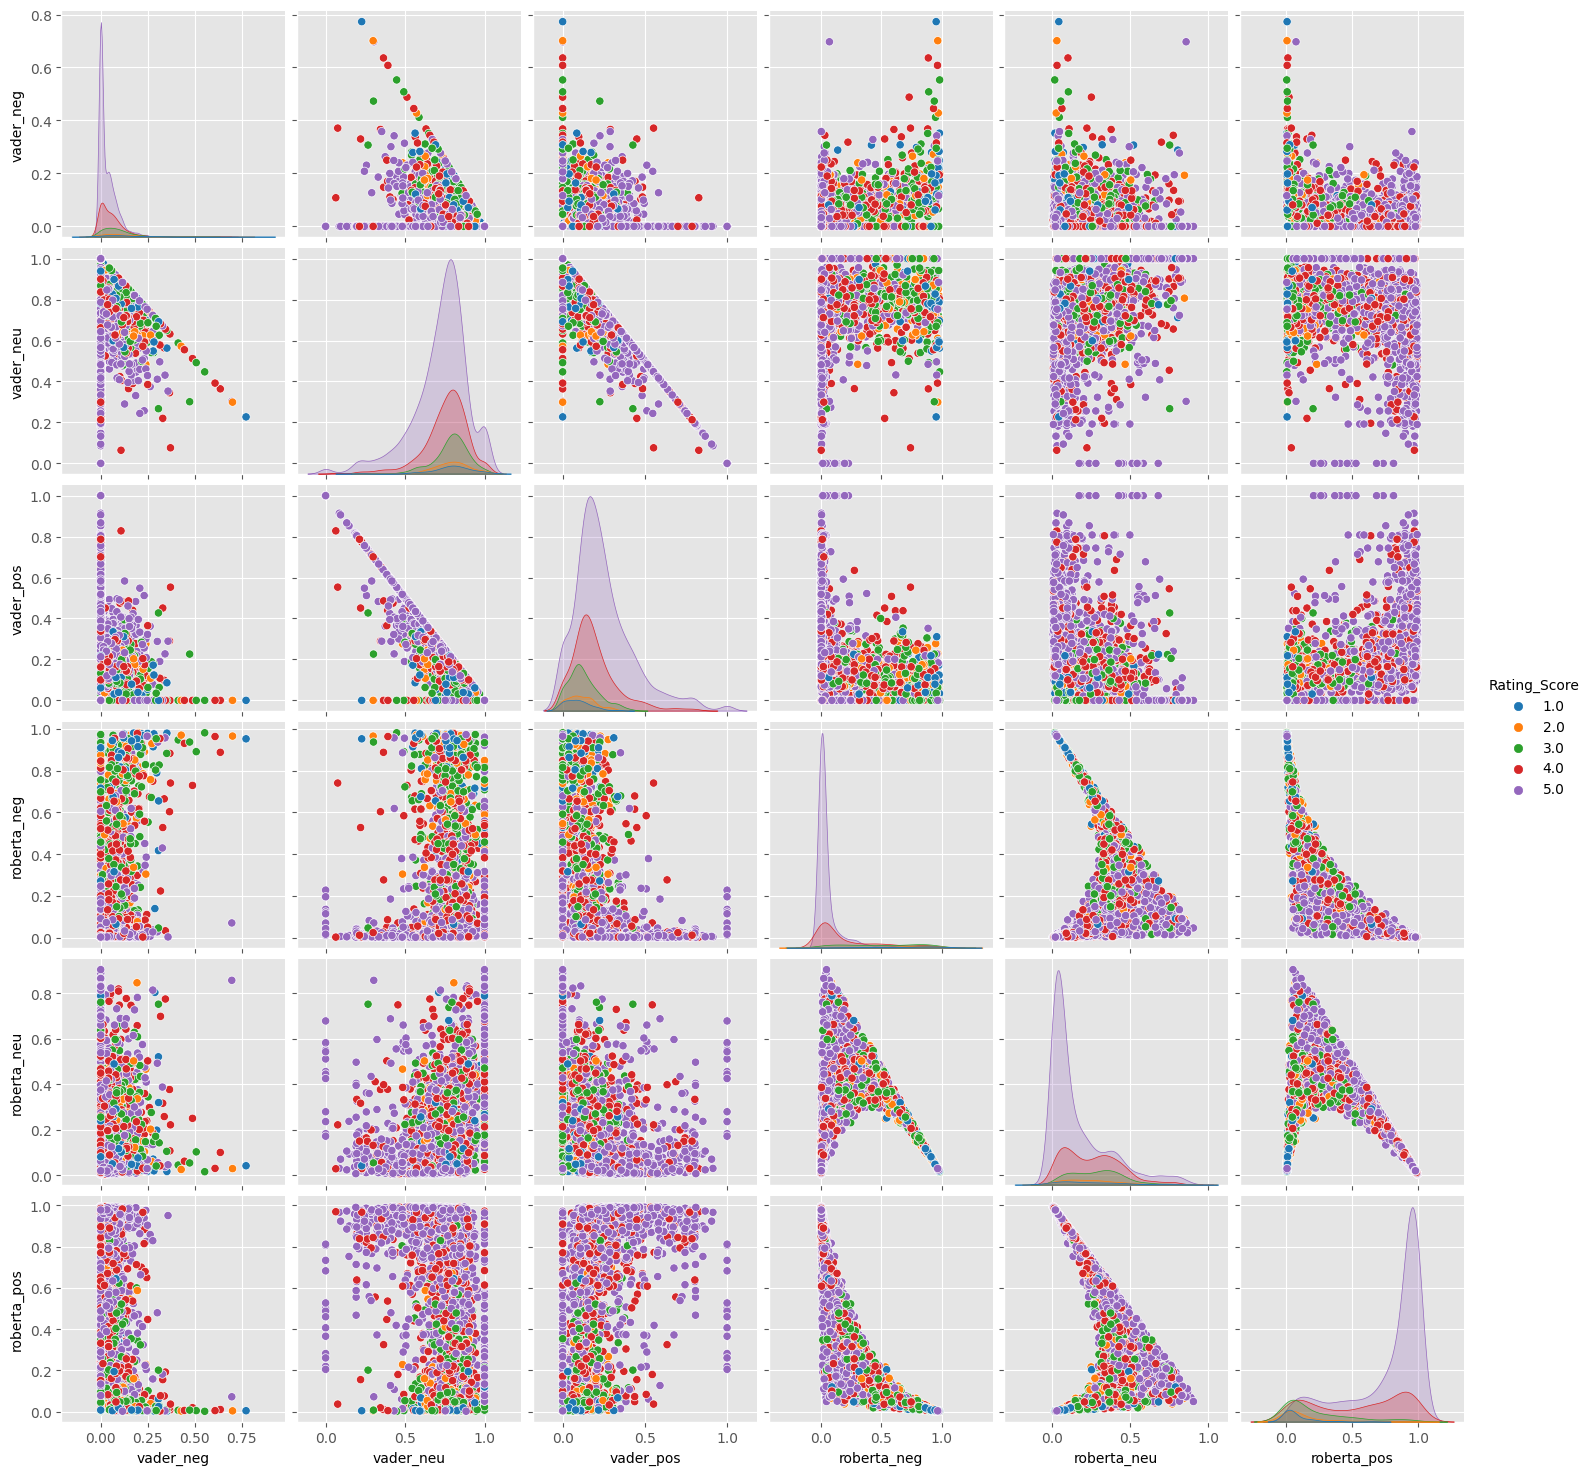

In [24]:
# Set up visualization
sns.pairplot(data = results_df,
             vars = ['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue = 'Rating_Score',
            palette = 'tab10')
plt.show()

## Scatter plot conclusion: Most comments for every whey protein product selled at Amazon were given 5-stars, hence most data points are purple (assigned by Python to comments with rating score of 5). Notice that there are corelations between Roberta & Vader - it's hard to tell but notice that most graphs reflect 'skewed'-looking patterns. Anyhow, the Vader model is less confident in all of it's predictions compared to Roberta. If you observe Roberta's results, positive predictions are distributed mostly towards 1.0 (positive) and negative predictions towards 0.0 (negative).

In [31]:
# Converting the results dataframe to a csv file
results_df.to_csv('Whey_Protein_Results_Roberta_vs_Vader.csv') 